# Imports

In [1]:
import spikeinterface.full as si
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
import spyglass.spikesorting as sgs

[2023-06-10 21:39:57,974][INFO]: Connecting kyu@lmf-db.cin.ucsf.edu:3306
[2023-06-10 21:39:58,021][INFO]: Connected kyu@lmf-db.cin.ucsf.edu:3306


# Helper functions

In [3]:
def get_recording(nwb_file_name, shank_id):
    recording_path = (sgs.SpikeSortingRecording & {"nwb_file_name":nwb_file_name,
                                                   "sort_group_id":shank_id}).fetch("recording_path")[0]
    recording = si.load_extractor(recording_path)
    if recording.get_num_segments()>1:
        recording = si.concatenate_recordings([recording])
    return recording

def get_sorting(nwb_file_name, shank_id):
    sorting_path = (sgs.SpikeSorting & {"nwb_file_name":nwb_file_name,
                                        "sort_group_id":shank_id}).fetch("sorting_path")[0]
    sorting = si.load_extractor(sorting_path)

    return sorting

def open_json(path):
    with open(path, 'r') as f:
        c = json.load(f)
    return c

def get_curation_labels(nwb_file_name, shank_id, path_to_sorting_curation_repo):
    curation_uri = (sgs.CurationFigurl & {"nwb_file_name": nwb_file_name,
                                          "sort_group_id":shank_id}).fetch("new_curation_uri")[0]
    local_path = curation_uri.replace('gh://LorenFrankLab/sorting-curations/main/', path_to_sorting_curation_repo)
    curation_labels = open_json(local_path)
    return curation_labels

def get_units_to_remove(curation_labels):
    exclude_labels = ['noise', 'reject', 'mua']
    units_to_remove = []
    for unit_id, labels in curation_labels['labelsByUnit'].items():
        if np.sum([i in exclude_labels for i in labels])>0:
            units_to_remove.append(int(unit_id))
    return units_to_remove

def curate_sorting(sorting, curation_labels, skip_merge=True):
    if curation_labels['labelsByUnit']:
        units_to_remove = get_units_to_remove(curation_labels)
        sorting = sorting.remove_units(units_to_remove)
    if curation_labels['mergeGroups'] and skip_merge==False:
        sorting = si.MergeUnitsSorting(parent_sorting=sorting,
                                       units_to_merge=curation_labels['mergeGroups'],
                                      )
    return sorting

def count_unique_ones(matrix):
    rows = len(matrix)
    cols = len(matrix[0])

    row_counts = [0] * rows
    col_counts = [0] * cols

    # Count the number of 1s in each row and column
    for i in range(rows):
        for j in range(cols):
            if matrix[i][j] == 1:
                row_counts[i] += 1
                col_counts[j] += 1

    unique_ones = 0

    # Count the number of 1s that are the only 1 in both row and column
    for i in range(rows):
        for j in range(cols):
            if matrix[i][j] == 1 and row_counts[i] == 1 and col_counts[j] == 1:
                unique_ones += 1

    return unique_ones

def find_unique_ones(matrix):
    rows = len(matrix)
    cols = len(matrix[0])

    row_counts = [0] * rows
    col_counts = [0] * cols

    # Count the number of 1s in each row and column
    for i in range(rows):
        for j in range(cols):
            if matrix[i][j] == 1:
                row_counts[i] += 1
                col_counts[j] += 1

    unique_ones = []
    
    # Find the 1s that are the only 1 in both row and column
    for i in range(rows):
        for j in range(cols):
            if matrix[i][j] == 1 and row_counts[i] == 1 and col_counts[j] == 1:
                unique_ones.append((i, j))

    return unique_ones



# Define NWB file names

In [4]:
nwb_file_name1 = "L520230420_.nwb"
nwb_file_name2 = "L520230421_.nwb"

shank_id = 3

# Load recording

In [5]:
recording1 = get_recording(nwb_file_name1, shank_id)
recording2 = get_recording(nwb_file_name2, shank_id)

# Load sorting

In [6]:
sorting1 = get_sorting(nwb_file_name1, shank_id)
sorting2 = get_sorting(nwb_file_name2, shank_id)

# Get manual curation labels

In [7]:
# change this to path on your system
!cd ~/repos/sorting-curations && git pull origin main
path_to_sorting_curation_repo = '/home/kyu/repos/sorting-curations/'

From https://github.com/LorenFrankLab/sorting-curations
 * branch            main       -> FETCH_HEAD
Already up to date.


In [8]:
curation_labels1 = get_curation_labels(nwb_file_name1, shank_id, path_to_sorting_curation_repo)
curation_labels2 = get_curation_labels(nwb_file_name2, shank_id, path_to_sorting_curation_repo)

# Apply curation to sorting

In [9]:
sorting1 = curate_sorting(sorting1, curation_labels1)
sorting2 = curate_sorting(sorting2, curation_labels2)

# Extract waveforms

In [10]:
waveform_extractor1 = si.extract_waveforms(recording1, sorting1, folder="/tmp/we1",
                                           ms_before=1.0, ms_after=1.0,
                                           max_spikes_per_unit=5000,
                                           overwrite=True,
                                           seed=47,
                                           dtype=np.float32
                                          )

extract waveforms memmap:   0%|          | 0/1203 [00:00<?, ?it/s]

In [11]:
waveform_extractor2 = si.extract_waveforms(recording2, sorting2, folder="/tmp/we2",
                                           ms_before=1.0, ms_after=1.0,
                                           max_spikes_per_unit=5000,
                                           overwrite=True,
                                           seed=47,
                                           dtype=np.float32
                                          )

extract waveforms memmap:   0%|          | 0/1204 [00:00<?, ?it/s]

# Find matching cells

## Method 1: nearest neighbor distance

In [12]:
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import IncrementalPCA

def _compute_contamination(pcs_target_unit, pcs_other_unit, n_neighbors: int):
    # get lengths
    n_spikes_target = pcs_target_unit.shape[0]
    n_spikes_other = pcs_other_unit.shape[0]

    # concatenate
    pcs_concat = np.concatenate((pcs_target_unit, pcs_other_unit), axis=0)
    label_concat = np.concatenate((np.zeros(n_spikes_target), np.ones(n_spikes_other)))

    # if n_neighbors is greater than the number of spikes in both clusters, set it to max possible
    if n_neighbors > len(label_concat):
        n_neighbors_adjusted = len(label_concat) - 1
    else:
        n_neighbors_adjusted = n_neighbors

    _, membership_ind = (
        NearestNeighbors(n_neighbors=n_neighbors_adjusted, algorithm="auto").fit(pcs_concat).kneighbors()
    )
    # print(label_concat[membership_ind[:n_spikes_target]].shape)
    target_nn_in_other = np.sum(label_concat[membership_ind[:n_spikes_target]] == 1)

    # target_nn_in_target = np.sum(label_concat[membership_ind[:n_spikes_target]] == 0)
    # other_nn_in_other = np.sum(label_concat[membership_ind[n_spikes_target:]] == 1)

    contamination = target_nn_in_other / (n_spikes_target) / n_neighbors_adjusted

    return contamination

def compute_nn_distance(waveform_extractor1, waveform_extractor2, radius_um=50, seed=47, n_neighbors=5, n_spikes=1000, n_components=5):
    
    rng = np.random.default_rng(seed=seed)
    
    sparsity1 = si.compute_sparsity(waveform_extractor1, method='radius', radius_um=radius_um)
    sparsity2 = si.compute_sparsity(waveform_extractor2, method='radius', radius_um=radius_um)
    
    output = np.zeros((waveform_extractor1.sorting.get_num_units(),
                       waveform_extractor2.sorting.get_num_units()))
    
    all_channels = waveform_extractor1.recording.get_channel_ids()
    # print(all_channels)
    assert np.array_equal(waveform_extractor1.recording.get_channel_ids(), waveform_extractor2.recording.get_channel_ids()), "the waveform extractors are not from the same shanks"
    
    for unit_id1 in waveform_extractor1.sorting.get_unit_ids():
        waveforms_unit1 = waveform_extractor1.get_waveforms(unit_id=unit_id1)

        for unit_id2 in waveform_extractor2.sorting.get_unit_ids():
            waveforms_unit2 = waveform_extractor2.get_waveforms(unit_id=unit_id2)
            
            n_spikes = np.min([waveforms_unit1.shape[0], waveforms_unit2.shape[0], n_spikes])
            
            channels_with_signal = np.concatenate((sparsity1.unit_id_to_channel_ids[unit_id1], sparsity2.unit_id_to_channel_ids[unit_id2]))
            channels_with_signal = np.unique(channels_with_signal)
            # print(sparsity1.unit_id_to_channel_ids[unit_id1])
            # print(sparsity2.unit_id_to_channel_ids[unit_id2])
            
            indices = np.where(np.isin(all_channels, channels_with_signal))[0]
            # print(indices)
            
            waveforms_unit1_sparse = waveforms_unit1[:,:,indices]
            waveforms_unit2_sparse = waveforms_unit2[:,:,indices]

            spike_ind1 = rng.choice(waveforms_unit1_sparse.shape[0], size=n_spikes, replace=False)
            spike_ind2 = rng.choice(waveforms_unit2_sparse.shape[0], size=n_spikes, replace=False)

            waveforms_unit1_sparse = waveforms_unit1_sparse[spike_ind1]
            waveforms_unit2_sparse = waveforms_unit2_sparse[spike_ind2]

            waveforms_unit1_sparse = np.reshape(waveforms_unit1_sparse, (n_spikes,-1))
            waveforms_unit2_sparse = np.reshape(waveforms_unit2_sparse, (n_spikes,-1))

            # concatenate
            waveforms_concat = np.concatenate((waveforms_unit1_sparse, waveforms_unit2_sparse), axis=0)
            
            pca = IncrementalPCA(n_components=n_components)
            pca.partial_fit(waveforms_concat)
            projected_waveforms = pca.transform(waveforms_concat)
            
            output[waveform_extractor1.sorting.get_unit_ids()==unit_id1,
                   waveform_extractor2.sorting.get_unit_ids()==unit_id2] = _compute_contamination(projected_waveforms[:n_spikes], projected_waveforms[n_spikes:], n_neighbors)
    return output

In [13]:
nn_distance = compute_nn_distance(waveform_extractor1, waveform_extractor2, radius_um=50, n_neighbors=5, n_spikes=2000, n_components=4)

In [14]:
nn_distance_threshold = 0.3

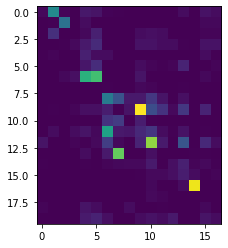

In [15]:
plt.imshow(nn_distance)

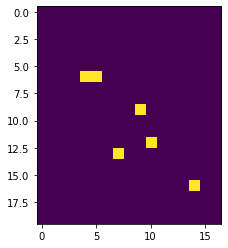

In [16]:
plt.imshow(nn_distance>nn_distance_threshold)

## Method 2: cosine similarity of mean waveforms at channels with signficant signal

In [22]:
import sklearn.metrics.pairwise

def compute_cosine_similarity(waveform_extractor1, waveform_extractor2, radius_um=50):
    sparsity1 = si.compute_sparsity(waveform_extractor1, method='radius', radius_um=radius_um)
    sparsity2 = si.compute_sparsity(waveform_extractor2, method='radius', radius_um=radius_um)

    output = np.zeros((waveform_extractor1.sorting.get_num_units(),
                       waveform_extractor2.sorting.get_num_units()))
    
    all_channels = waveform_extractor1.recording.get_channel_ids()
    assert np.array_equal(waveform_extractor1.recording.get_channel_ids(), waveform_extractor2.recording.get_channel_ids()), "the waveform extractors are not from the same shanks"
    for unit_id1 in waveform_extractor1.sorting.get_unit_ids():
        
        for unit_id2 in waveform_extractor2.sorting.get_unit_ids():
            
            channels_with_signal = np.concatenate((sparsity1.unit_id_to_channel_ids[unit_id1], sparsity2.unit_id_to_channel_ids[unit_id2]))
            channels_with_signal = np.unique(channels_with_signal)
            indices = np.where(np.isin(all_channels, channels_with_signal))[0]

            template_unit1 = waveform_extractor1.get_template(unit_id=unit_id1)
            template_unit1 = template_unit1[:,indices]
            template_unit1 = template_unit1.flatten()
            template_unit1 = np.expand_dims(template_unit1, axis=0)
            
            template_unit2 = waveform_extractor2.get_template(unit_id=unit_id2)
            template_unit2 = template_unit2[:,indices]
            template_unit2 = template_unit2.flatten()
            template_unit2 = np.expand_dims(template_unit2, axis=0)

            output[waveform_extractor1.sorting.get_unit_ids()==unit_id1,
                   waveform_extractor2.sorting.get_unit_ids()==unit_id2] = sklearn.metrics.pairwise.cosine_similarity(template_unit1, template_unit2)
    return output

In [23]:
cos_sim = compute_cosine_similarity(waveform_extractor1, waveform_extractor2)

In [24]:
cos_sim_threshold = 0.99

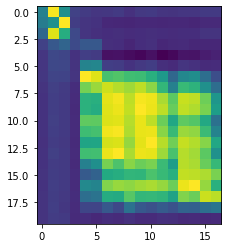

In [25]:
plt.imshow(cos_sim)

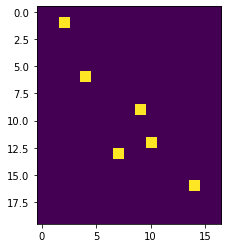

In [26]:
plt.imshow(cos_sim>cos_sim_threshold)

## Method 3: Pearson correlation of autocorrelograms (50 ms window around zero time shift)

In [29]:
import sklearn.metrics.pairwise

from scipy.stats import pearsonr

def compute_acc_similarity(sorting1, sorting2, window_ms=100, bin_ms=2):
    
    corr1, _ = si.compute_correlograms(sorting1, window_ms=window_ms, bin_ms=bin_ms, method="numpy")
    ac1 = np.zeros((corr1.shape[0], corr1.shape[-1]))
    for i in range(corr1.shape[0]):
        ac1[i] = corr1[i,i,:]
        
    corr2, _ = si.compute_correlograms(sorting2, window_ms=window_ms, bin_ms=bin_ms, method="numpy")
    ac2 = np.zeros((corr2.shape[0], corr2.shape[-1]))
    for i in range(corr2.shape[0]):
        ac2[i] = corr2[i,i,:]
        
    output = np.zeros((sorting1.get_num_units(), sorting2.get_num_units()))
    for i in range(ac1.shape[0]):
        for j in range(ac2.shape[0]):
            k, _ = pearsonr(ac1[i], ac2[j])
            output[i,j]=k
    return output

In [30]:
ac_sim = compute_acc_similarity(sorting1, sorting2)    

In [31]:
ac_threshold = 0.95

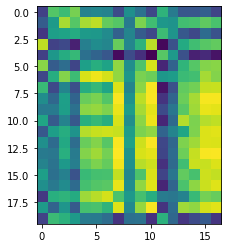

In [32]:
plt.imshow(ac_sim)

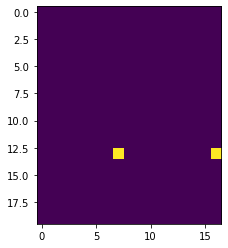

In [33]:
plt.imshow(ac_sim>ac_threshold
          )

# Combining multiple criteria?

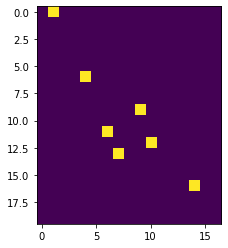

In [35]:
plt.imshow((nn_distance>0.2) * (cos_sim>0.95))

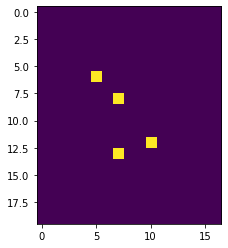

In [37]:
plt.imshow((nn_distance>0.1) * (cos_sim>0.9) * (ac_sim>0.9))

## How does the number of unique match change as a function of the threshold?

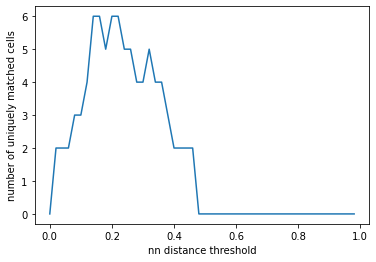

In [17]:
t = np.arange(0,1,0.02)
k = []
for i in t:
    k.append(count_unique_ones(nn_distance>i))

fig, ax = plt.subplots()
ax.plot(t,k)
ax.set_xlabel('nn distance threshold');
ax.set_ylabel('number of uniquely matched cells');

## Find matches

### Could just count uniquely matched cells

In [18]:
k = find_unique_ones(nn_distance>nn_distance_threshold)
match = {}
for unit_idx1, unit_idx2 in k:
    match[waveform_extractor1.sorting.get_unit_ids()[unit_idx1]] =  waveform_extractor2.sorting.get_unit_ids()[unit_idx2]

### ...or match the most similar pair, remove the row and column it is on, and continue until the max similarity falls under threshold

In [19]:
import numpy as np

def match_best_first(matrix, threshold):
    max_values = []
    original_indices = []  # List to store the original indices of maximum values
    new_matrix = matrix
    while True:
        
        max_value = np.max(new_matrix)  # Find the maximum value in the matrix
        if max_value <= threshold:
            break  # Stop if no value exceeds the threshold
        
        i, j = np.where(matrix==max_value)
        i = i[0]
        j = j[0]
        
        original_indices.append((i,j))
        max_values.append(max_value)

        ii, jj = np.where(new_matrix==max_value)
        ii = ii[0]
        jj = jj[0]

        # max_index = np.unravel_index(np.argmax(new_matrix), new_matrix.shape)  # Get the index of the maximum value
        
        # Store the original index
        # original_indices.append(max_index)
        # max_values.append(max_value)
        # Remove the row and column of the maximum value
        new_matrix = np.delete(new_matrix, ii, axis=0)
        new_matrix = np.delete(new_matrix, jj, axis=1)
        if new_matrix.shape == (0,0):
            break
    # Print or return the original indices
    return max_values, original_indices

In [20]:
_, k = match_best_first(nn_distance, nn_distance_threshold)

match = {}
for unit_idx1, unit_idx2 in k:
    match[waveform_extractor1.sorting.get_unit_ids()[unit_idx1]] =  waveform_extractor2.sorting.get_unit_ids()[unit_idx2]

### Compare matches (using only nearest neighbor distance)
- average waveform
- firing rate
- ISI distribution
- place field

In [79]:
nwb_path = '/stelmo/nwb/raw/'

with pynwb.NWBHDF5IO(nwb_path + nwb_file_name1.replace('_', ''), load_namespaces=True, mode='r') as io:
    f = io.read()
    # print(f.epochs['tags'])
    pos1 = f.processing['behavior']['position']['series_0'].data[:]
    t_pos1 = f.processing['behavior']['position']['series_0'].timestamps[:]
    ephys_time1 = f.acquisition['e-series'].timestamps[:]
    
with pynwb.NWBHDF5IO(nwb_path + nwb_file_name2.replace('_', ''), load_namespaces=True, mode='r') as io:
    f = io.read()
    # print(f.processing['behavior']['position'])
    # print(f.epochs['tags'][:])
    pos2 = f.processing['behavior']['position']['series_0'].data[:]
    t_pos2 = f.processing['behavior']['position']['series_0'].timestamps[:]
    ephys_time2 = f.acquisition['e-series'].timestamps[:]

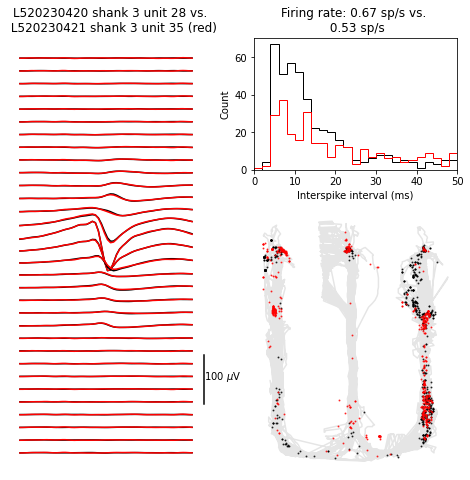

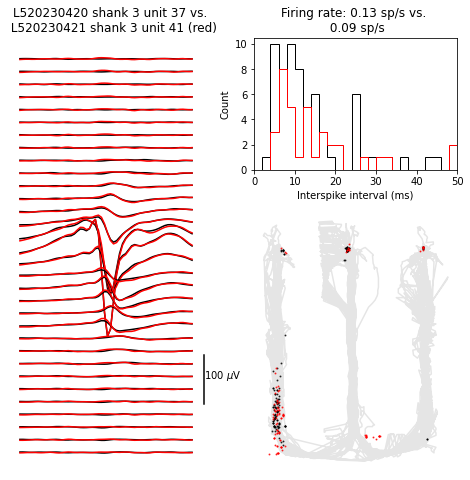

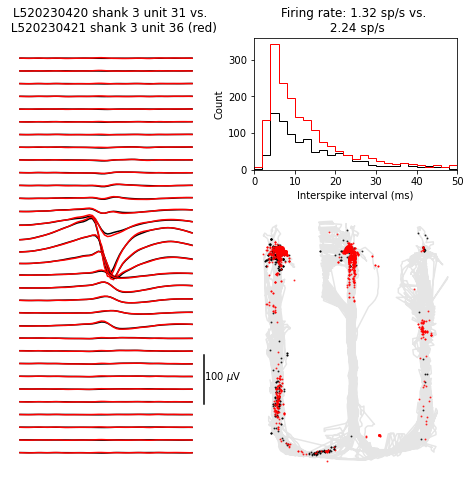

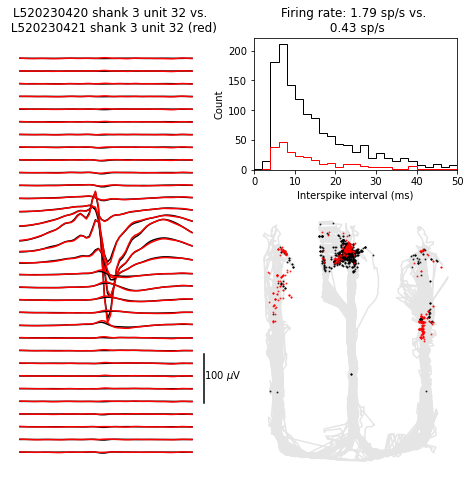

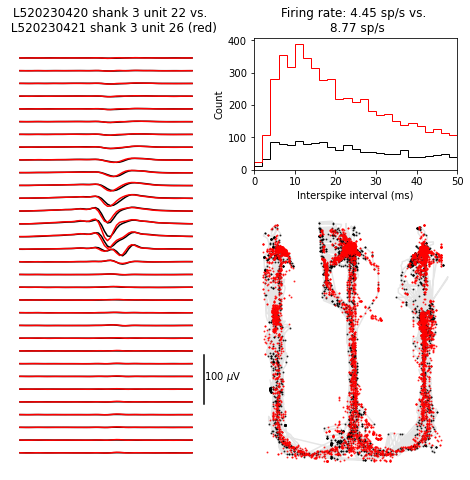

In [103]:
t = np.linspace(0,1,waveform_extractor1.nsamples)
bins = np.arange(0, 100, 2)

scale_x = 140
scale_y = 0.4

for unit_id in list(match.keys()):
    # fig, (ax1, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [3.5, 1, 1]}, figsize=(3,10))
    # fig.subplots_adjust(hspace=0.01)
    
    
    # Create the figure and GridSpec
    fig = plt.figure(figsize=(8,8))
    gs = GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1,2])

    # Create subplots
    ax1 = fig.add_subplot(gs[:, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])

    for i in range(waveform_extractor1.get_num_channels()):
        x, y = waveform_extractor1.get_channel_locations()[i]
        ax1.plot(t+x/scale_x, waveform_extractor1.get_template(unit_id=unit_id)[:,i]+y/scale_y, 'k')
        ax1.plot(t+x/scale_x, waveform_extractor2.get_template(unit_id=match[unit_id])[:,i]+y/scale_y, 'r')


    ax1.plot([(x+150)/scale_x, (x+150)/scale_x], [(y+100)/scale_y, (y+200)/scale_y], 'k-')
    ax1.text((x+150)/scale_x, (y+150)/scale_y, '100 $\mu$V')
    
    # textcolor = 'red'
    # title1 = f"{nwb_file_name1[:-5]} shank {shank_id} unit {unit_id} vs. $\color{{{textcolor}}}{\mathrm{{color}}}$"
    # title2 = fr"$\color{textcolor}{{nwb_file_name2[:-5]} shank {shank_id} unit {match[unit_id]} }$"

    # ax.set_title(title1+title2)
    ax1.set_title(f"{nwb_file_name1[:-5]} shank {shank_id} unit {unit_id} vs. \n {nwb_file_name2[:-5]} shank {shank_id} unit {match[unit_id]} (red)")
    
    ax1.set_axis_off()
        
    spike_times_ms1 = waveform_extractor1.sorting.get_unit_spike_train(unit_id=unit_id)/waveform_extractor1.sampling_frequency*1e3
    spike_times_ms2 = waveform_extractor2.sorting.get_unit_spike_train(unit_id=match[unit_id])/waveform_extractor2.sampling_frequency*1e3
    
    fr1 = len(spike_times_ms1)/(spike_times_ms1[-1]-spike_times_ms1[0])*1e3
    fr2 = len(spike_times_ms2)/(spike_times_ms2[-1]-spike_times_ms2[0])*1e3
    
    ax2.hist(np.diff(spike_times_ms1), bins=bins, color='k', histtype='step')
    ax2.hist(np.diff(spike_times_ms2), bins=bins, color='r', histtype='step')
    
    ax2.set_xlim([0,50])
    ax2.set_xlabel("Interspike interval (ms)")
    ax2.set_ylabel("Count")
    ax2.set_title(f"Firing rate: {round(fr1,2)} sp/s vs. \n {round(fr2,2)} sp/s")
    
    spike_times1 = waveform_extractor1.sorting.get_unit_spike_train(unit_id)
    spike_times1 = ephys_time1[spike_times1]
    
    spike_times2 = waveform_extractor2.sorting.get_unit_spike_train(match[unit_id])
    spike_times2 = ephys_time2[spike_times2]
    
    ind1 = np.searchsorted(t_pos1, spike_times1)
    ind1 = ind1[ind1<len(pos1)]
    
    ind2 = np.searchsorted(t_pos2, spike_times2)
    ind2 = ind2[ind2<len(pos2)]
    
    ax3.plot(pos1[:,2], pos1[:,3], 'k', alpha=0.1)
    # ax3.plot(pos1[:,2], pos1[:,3], 'k', alpha=0.1)

    ax3.plot(pos1[ind1,2], pos1[ind1,3], 'k.', markersize=2., alpha=0.7)
    ax3.plot(pos2[ind2,2], pos2[ind2,3], 'r.', markersize=2., alpha=0.7)
    ax3.set_axis_off()



    # fig.savefig(savedir + f'/{unit_idx}.png', bbox_inches='tight',)   # save the figure to file
    # plt.close(fig)    # close the figure window

5/26 vs 5/31
- shank0: 9/28
- shank1: 4/6
- shank2: 3/5
- shank3: 2/11
- total: 18/50
